# Testing Code To Apply PDR Satellite Fraction Finding to UM Model Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table , Column
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# import the data file
data_pth = '/Users/astro/Desktop/github/satellite_fraction/data/'
model = data_pth + 'um_smdpl_model_logms_tot_11.4.fits'
pdr = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo_pdr_full.fits'


# open pdr file
pdr_open = fits.open(pdr)
z_pdr = pdr_open[1].data['z_best']

In [3]:
# create astropy table of useful data
hdu1 = fits.open(model)
full_table = Table(hdu1[1].data)
# Get only the galaxies within our mass range
model_table = Table(names = full_table.colnames)

for i in range(len(np.array(full_table['logms_tot_mod']))):
    if full_table['logms_tot_mod'][i] > 11.50:
        model_table.add_row(full_table[i])
        
        
model_table.sort('logms_tot_mod')
model_table.reverse() # rank order by mass
model_redshift = 0.37 # this is from um snapshot

print(len(model_table))

13358


## Test halotools

In [4]:
# remember that some galaxies lack specz => error
from halotools.mock_observables import apply_zspace_distortion
from astropy.cosmology import Planck15 as cosmo # um uses planck cosmology
# find the z-space distortions
z_dis = apply_zspace_distortion(model_table['z'], model_table['vz'], model_redshift, cosmo, 400.0)
model_table['z_dist'] = z_dis

/Users/astro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Text(0,0.5,'LOS space distortion')

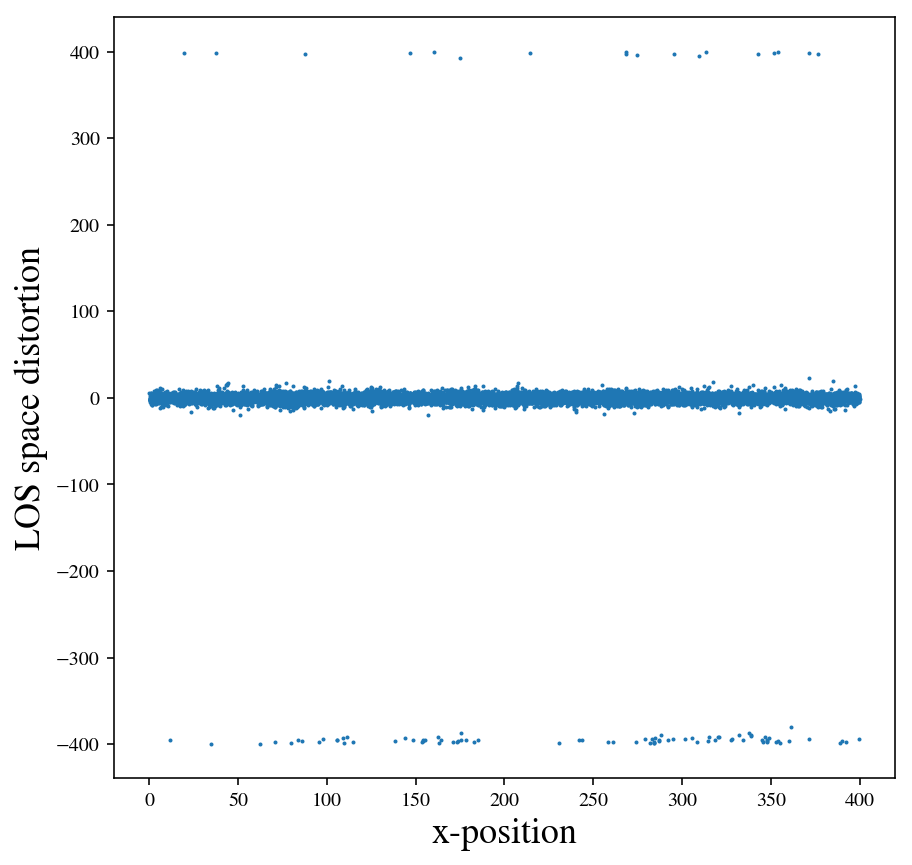

In [5]:
# look at redshift space distortions
fig = plt.figure(figsize = [7,7])

ax1 = fig.add_subplot(111)
ax1.scatter(model_table['x'],model_table['z'] - model_table['z_dist'], s = 1)
ax1.set_xlabel('x-position', fontsize = 18)
ax1.set_ylabel('LOS space distortion', fontsize = 18)

So it looks like the z-space distortions aren't bad. (The odd points at $\pm400$ are from the box size of the um model, which is $400Mpc$)

* Some of the galaxy positions are now weird because of the periodic boundary conditions.

(array([311., 268., 241., 270., 287., 261., 255., 243., 205., 268., 264.,
        246., 221., 195., 203., 225., 220., 278., 246., 241., 247., 287.,
        233., 257., 238., 231., 270., 299., 306., 305., 276., 236., 240.,
        249., 283., 265., 274., 304., 294., 376., 409., 346., 261., 298.,
        313., 302., 221., 250., 270., 270.]),
 array([3.57112194e-02, 8.03437159e+00, 1.60330320e+01, 2.40316923e+01,
        3.20303527e+01, 4.00290131e+01, 4.80276735e+01, 5.60263338e+01,
        6.40249942e+01, 7.20236546e+01, 8.00223149e+01, 8.80209753e+01,
        9.60196357e+01, 1.04018296e+02, 1.12016956e+02, 1.20015617e+02,
        1.28014277e+02, 1.36012938e+02, 1.44011598e+02, 1.52010258e+02,
        1.60008919e+02, 1.68007579e+02, 1.76006239e+02, 1.84004900e+02,
        1.92003560e+02, 2.00002221e+02, 2.08000881e+02, 2.15999541e+02,
        2.23998202e+02, 2.31996862e+02, 2.39995522e+02, 2.47994183e+02,
        2.55992843e+02, 2.63991503e+02, 2.71990164e+02, 2.79988824e+02,
        2.

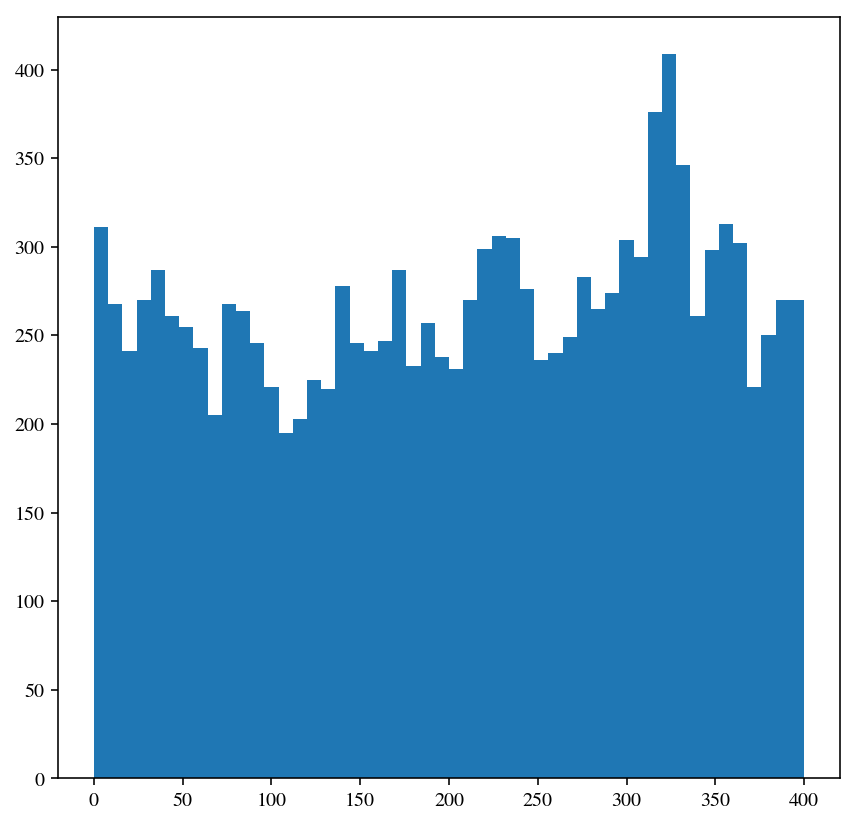

In [6]:
plt.figure(figsize = (7,7))
plt.hist(model_table['z_dist'], bins = 50)

* The next order of business is to turn the $\Delta z$ into physical $\Delta \ell$ (I think). From my conversation with Alexie at Shane, I want to convert our z-limits to comoving $h^{-1}$. For this, I can use `colossus.cosmology.comovingDistance`.

In [7]:
# first define the cosmology in colossus
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 70.0 , 'Om0': 0.3 , 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
h = .7
cosmology.addCosmology('huang18',params) # this is what Song had me use when doing the sat frac
cosmo = cosmology.setCosmology('huang18')
from colossus.halo import mass_so

In [8]:
# find the comoving distance to use as a z-cut for the catalog
# for the dl cut, I will use the mean redshift plus our velocity dispersion
z_mean = np.mean(z_pdr)
z_l = z_mean + .05 # the .05 is what we will vary in our analysis
l = cosmo.comovingDistance(z_mean, z_l)
print(l)

121.71649170765623


So comoving distance $\Delta \ell \approx 12.33 Mpch^{-1}$ for $\Delta z = 0.005$ 

Now I want to find the satellite fraction through the same process as the pdr region, except with a length cut.


### Apply same method to catalog

## True Satellite Fraction

* I just copy/pasted this from my other notebook. It needs some edits to keep it in similar form as other method

In [9]:
centrals_true = []
sats_true = []

for i in range(len(model_table)):
    if model_table['upid'][i] == -1:
        centrals_true.append(model_table['logms_tot_mod'][i])
    else:
        sats_true.append(model_table['logms_tot_mod'][i])
        
        
# range of masses
mmin = np.min(model_table['logms_tot_mod'])
mmax = np.max(model_table['logms_tot_mod'])


# from Song's satellite finding code

hist_cen, edges_cen = np.histogram(centrals_true, range = [11.5,mmax], bins=8)
hist_sat, edges_sat = np.histogram(sats_true, range = [11.5,mmax], bins=8)

mass_center_true = (edges_cen[1:] + edges_cen[:-1]) / 2

f_sat_true = (hist_sat / hist_cen) * 100

In [10]:
# get virial radii
mvir = model_table['logmh_vir']
model_table['r_vir'] = (mass_so.M_to_R((10**mvir)*h , model_redshift, '200m')/h)*1e-3 #Mpc/h

# Make an index column
model_table['index'] = np.zeros(len(model_table['logms_tot_mod']))
for i in range(len(model_table['index'])):
     model_table['index'][i] = i

$\Rightarrow$ When I am applying this method, there are two key differences from the PDR
* $\Delta z$ cut is now a $\Delta \ell$ cut
* Distance between galaxies is calculated using x-y coordinates instead of RA and Dec

From what Marie sent me of the meeting on 6/21, I should be using these $\ell$ cuts:
* $\ell = 10Mpch^{-1}$
* $\ell = 15Mpch^{-1}$ $\Rightarrow$ velocity dispersion
* $\ell = 20Mpch^{-1}$
* $\ell = 50Mpch^{-1}$
* $\ell = 100Mpch^{-1}$ $\Rightarrow$ HSC $\sigma$

In [11]:
import satellite_finder as sf

#### Run using different  $\ell$ cuts

#### First, $\ell = 10$

In [12]:
# using l=10
mass_center_10mpc, f_sat_10mpc, err_10mpc = sf.run_model_satellite(model_table, 10)

#### Now use Chris' $\Delta \ell \sim 15Mpch^{-1}$

In [13]:
mass_center_15mpc, f_sat_15mpc, err_15mpc = sf.run_model_satellite(model_table, 15)

#### $\ell = 20$

In [14]:
mass_center_20mpc, f_sat_20mpc, err_20mpc = sf.run_model_satellite(model_table, 20)

#### $\ell = 50$

In [15]:
mass_center_50mpc, f_sat_50mpc, err_50mpc = sf.run_model_satellite(model_table, 50)

#### $\ell = 100$

In [16]:
mass_center_100mpc, f_sat_100mpc, err_100mpc = sf.run_model_satellite(model_table, 100)

--------------- Error Bars --------------
* Song said I should put some "naive" error bars for reference. I will just do counting error.
$$ \sigma = \sqrt{n_{sat}}/n_{cent} * 100 $$

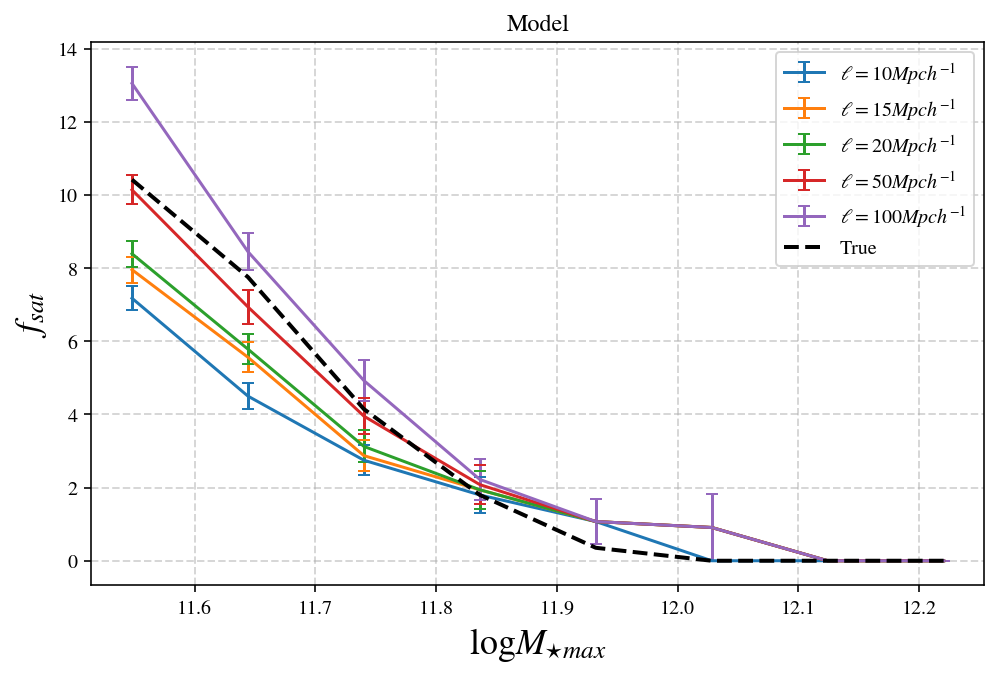

In [17]:
fig = plt.figure(figsize = [8,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.errorbar(mass_center_10mpc , f_sat_10mpc, yerr = err_10mpc, capsize = 3, label = '$\ell = 10Mpch^{-1}$')
ax1.errorbar(mass_center_15mpc , f_sat_15mpc, yerr = err_15mpc, capsize = 3, label = '$\ell = 15Mpch^{-1}$')
ax1.errorbar(mass_center_20mpc , f_sat_20mpc, yerr = err_20mpc, capsize = 3, label = '$\ell = 20Mpch^{-1}$')
ax1.errorbar(mass_center_50mpc , f_sat_50mpc, yerr = err_50mpc, capsize = 3, label = '$\ell = 50Mpch^{-1}$')
ax1.errorbar(mass_center_100mpc , f_sat_100mpc, yerr = err_100mpc, capsize = 3, label = '$\ell = 100Mpch^{-1}$')
ax1.errorbar(mass_center_true , f_sat_true, color = 'k', linewidth = 2,ls = '--', label = 'True')


ax1.set_xlabel(r'$\log M_{\star max}$', fontsize = 18)
ax1.set_ylabel(r'$f_{sat}$', fontsize = 18)
ax1.set_title('Model')
ax1.legend()

#### Now we want to mock up photo-z errors.

**I'm not 100% clear on the process, but here is what I am going to do first:**

1) Using `numpy.random.rand()`, I will draw `len(model_table)*.06` random numbers

2) I will multiply the array of random numbers by `len(model_table)`, then convert those numbers to integers.

3) The integers will correspond to the indices of the rows of the table. These will be given the extra distortion, which I will work on next.

In [18]:
# Find how many random numbers to draw
n_with_photoz = len(model_table) * .09
n_to_draw = np.int(n_with_photoz) # round to integer to take from random fn

random_sample = np.random.rand(n_to_draw)
random_index = random_sample * len(model_table)

# Turn array of indices into integers
for i in range(len(random_index)):
    random_index[i] = np.int(random_index[i])
    

random_index_integer = random_index.astype(int) # this is the final array of numbers to use

This next part (actually creating and applying the kick) is where I'm a bit more unclear. I'm going to do what I *think* I'm supposed to do and see where that gets me. I will lay that out in the following markdown cell.

So from what Marie sent, I'm looking at a scatter of the form
$$ \sigma = \frac{\Delta z}{1 + z} \sim 0.03$$
If I'm supposed to find the $\Delta z$ and the corresponding comoving distance, then I would rearrange the function as $ \Delta z \sim 0.03(1 + z) $. In this case, $ z = z_{UM} = .37 $. Plugging in yields $\Delta z \sim 0.04$. From this, I can use `cosmo.comovingDistance()` to find the $\ell$. Once I have that, I will use `np.random.normal(0.0, cosmo.comovingDistance(.37, .37+.04))` for the kick.

In [19]:
delta_z = 0.04 # from above
l_comoving = cosmo.comovingDistance(0.37, 0.37 +delta_z)
print(l_comoving)

# here are the random distortions
l_kick = np.random.normal(0.0, l_comoving, size = len(random_index))

97.72030057321244


In [20]:
# ---------- Now add the distortions to the model data ----------

# Copy the original table so I can mess with the z-column
model_table_with_kick = copy.deepcopy(model_table)


# Add errors to the random rows
for i in range(len(random_index_integer)):
    model_table_with_kick['z_dist'][random_index_integer[i]] = \
    model_table_with_kick['z_dist'][random_index_integer[i]] + l_kick[i]

In [21]:
# ---------- Now run sat finding code ---------


# ---------- l = 10 ---------------------------------------
(mass_center_10mpc_kick, 
 f_sat_10mpc_kick, 
 err_10mpc_kick )= sf.run_model_satellite(model_table_with_kick, 10)

In [22]:
# ---------- l = 15 ---------------------------------------

(mass_center_15mpc_kick, 
 f_sat_15mpc_kick, 
 err_15mpc_kick )= sf.run_model_satellite(model_table_with_kick, 15)

In [23]:
# ---------- l = 20 ---------------------------------------

(mass_center_20mpc_kick, 
 f_sat_20mpc_kick, 
 err_20mpc_kick )= sf.run_model_satellite(model_table_with_kick, 20)

In [ ]:
# ---------- l = 50 ---------------------------------------

(mass_center_50mpc_kick, 
 f_sat_50mpc_kick, 
 err_50mpc_kick )= sf.run_model_satellite(model_table_with_kick, 50)

In [ ]:
# ---------- l = 100 ---------------------------------------

(mass_center_100mpc_kick, 
 f_sat_100mpc_kick, 
 err_100mpc_kick )= sf.run_model_satellite(model_table_with_kick, 100)

In [ ]:
fig = plt.figure(figsize = [30,10])
ax1 = fig.add_subplot(121)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.errorbar(mass_center_10mpc , f_sat_10mpc, yerr = err_10mpc, capsize = 3, label = '$\ell = 10Mpch^{-1}$')
ax1.errorbar(mass_center_15mpc , f_sat_15mpc, yerr = err_15mpc, capsize = 3, label = '$\ell = 15Mpch^{-1}$')
ax1.errorbar(mass_center_20mpc , f_sat_20mpc, yerr = err_20mpc, capsize = 3, label = '$\ell = 20Mpch^{-1}$')
ax1.errorbar(mass_center_50mpc , f_sat_50mpc, yerr = err_50mpc, capsize = 3, label = '$\ell = 50Mpch^{-1}$')
ax1.errorbar(mass_center_100mpc , f_sat_100mpc, yerr = err_100mpc, capsize = 3, label = '$\ell = 100Mpch^{-1}$')
ax1.errorbar(mass_center_true , f_sat_true, color = 'k', linewidth = 2,ls = '--', label = 'True')


ax1.set_xlabel(r'$\log M_{\star max}$', fontsize = 20)
ax1.set_ylabel(r'$f_{sat}$', fontsize = 20)
ax1.set_title('Model', fontsize = 20)
ax1.legend(fontsize = 20)

ax2 = fig.add_subplot(122, sharey = ax1)
ax2.grid(linewidth=1, linestyle='--', alpha=0.5)

ax2.errorbar(mass_center_10mpc_kick , f_sat_10mpc_kick, yerr = err_10mpc_kick, capsize = 3, label = '$\ell = 10Mpch^{-1}$')
ax2.errorbar(mass_center_15mpc_kick , f_sat_15mpc_kick, yerr = err_15mpc_kick, capsize = 3, label = '$\ell = 15Mpch^{-1}$')
ax2.errorbar(mass_center_20mpc_kick , f_sat_20mpc_kick, yerr = err_20mpc_kick, capsize = 3, label = '$\ell = 20Mpch^{-1}$')
ax2.errorbar(mass_center_50mpc_kick , f_sat_50mpc_kick, yerr = err_50mpc_kick, capsize = 3, label = '$\ell = 50Mpch^{-1}$')
ax2.errorbar(mass_center_100mpc_kick , f_sat_100mpc_kick, yerr = err_100mpc_kick, capsize = 3, label = '$\ell = 100Mpch^{-1}$')
ax2.errorbar(mass_center_true , f_sat_true, color = 'k', linewidth = 2,ls = '--', label = 'True')


ax2.set_xlabel(r'$\log M_{\star max}$', fontsize = 20)
ax2.set_ylabel(r'$f_{sat}$', fontsize = 20)
ax2.set_title('Model + Mock Photo-z Error', fontsize = 20)
ax2.legend(fontsize = 20)

plt.savefig('f_sat_two_panel.eps', dpi = 1000)